# midinet saの学習
とりあえずMidiNetにSelfAttentionを挟んでみるモデル

In [1]:
import os, glob, time, ipdb, pickle, numpy as np
visible_devices = [2]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
from multi_gpu import MultiGPUWrapper
from utils import Timer, get_model
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

## Modelの作成

#### model用共通関数の作成

In [5]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=True):
    if x.ndim == 2:
        return nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    elif x.ndim == 3:
        return nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    else:
        return x

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

#### Self Attention

In [1]:
class SelfAttention(nn.Module):
    """ Self Attention Layer """
    
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        
        # Self Attention の学習に使用する層を定義
        
        # pointwise convolutionによる特徴量変換，圧縮
        # Attention Mapに使われるxは3つあり，それぞれに対して適用
        # これが非常に大きなカーネルを設定するよりも高速になるらしい
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,kernel_size=1)
        
        # Attention Map 作成時の規格化用Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention Mapにかける係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x, get_map=False):
        
        # (B, C', W, H) -> (B, C', N)
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        
        # 転置 x^t
        proj_query = proj_query.permute(0, 2, 1)
        
        # 転置してない方の x
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2] * x.shape[3]) # (B, C', N)
        
        # バッチごとに行列の掛け算 x^t x を行う
        S = torch.bmm(proj_query, proj_key)
        
        # 規格化と転置を行い，Attention Mapを作成
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        
        # xに対応する調整量 o を取得
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]) # (B, C', N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # x + gamma o　を返す
        o = o.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        out = x + self.gamma * o
        
        if get_map:
            return out, attention_map
        else:
            return out

NameError: name 'nn' is not defined

#### Generator
SAを挟む

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 48, 64): 前の小節
- condition (batch, 54): 最初の12次元×4は拍ごとの和音, 最後の6次元はセクション

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

In [7]:
class Generator(nn.Module):
    def __init__(self, nz=100, pitch_range=64):
        super(Generator, self).__init__()
        self.nz      = nz
        self.y_dim   = 48
        
        self.prev_ch = 16
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h5      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))

        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h3_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(3,1), stride=(3,1))
        self.h4_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        
        self.sa1 = SelfAttention(self.gf_dim+self.y_dim+self.prev_ch)
        self.sa2 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa3 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa4 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa5 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        
        self.linear1 = nn.Linear(self.nz + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        
        batch_size = len(z)
        
        h0_prev = lrelu(batch_norm(self.h0_prev(prev_x)))   # 72, 16, 48, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(batch_norm(self.h1_prev(h0_prev)))  # 72, 16, 24, 1
        h2_prev = lrelu(batch_norm(self.h2_prev(h1_prev)))  # 72, 16, 12, 1
        h3_prev = lrelu(batch_norm(self.h3_prev(h2_prev)))  # 72, 16, 4, 1
        h4_prev = lrelu(batch_norm(self.h4_prev(h3_prev)))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 48, 1, 1

        z = torch.cat((z,y),1)                              # 72, 148

        h0 = F.relu(batch_norm(self.linear1(z)))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1072

        h1 = F.relu(batch_norm(self.linear2(h0)))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        h1 = concat_vector(h1, yb)                          # 72, 176, 2, 1
        h1 = concat_vector(h1, h4_prev)                     # 72, 192, 2, 1
        # h1 = self.sa1(h1)

        h2 = F.relu(batch_norm(self.h1(h1)))                # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 112, 4, 1
        h2 = concat_vector(h2, h3_prev)                     # 72, 128, 4, 1
        # h2 = self.sa2(h2)

        h3 = F.relu(batch_norm(self.h2(h2)))                # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 112, 12, 1
        h3 = concat_vector(h3, h2_prev)                     # 72, 128, 12, 1
        h3 = self.sa3(h3)

        h4 = F.relu(batch_norm(self.h3(h3)))                # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 112, 24, 1
        h4 = concat_vector(h4, h1_prev)                     # 72, 128, 24, 1
        h4 = self.sa4(h4)
        
        h5 = F.relu(batch_norm(self.h4(h4)))                # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 112, 48, 1
        h5 = concat_vector(h5, h0_prev)                     # 72, 128, 48, 1
        # h4 = self.sa5(h5)
        
        g_x = torch.sigmoid(self.h5(h5))                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み

        return g_x

動作確認

#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- y (batch, 54) = (72, 54): コード＋セクションの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果
- fm (batch, 1+13, steps, pitch) = (72, 109, 8, 1): 特徴マップ．

こちらも層を1つ追加  
思ったんだけどprev_xは識別に使わなくていいの？

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nz=100, pitch_range=64):
        super(Discriminator, self).__init__()
        self.y_dim = 48

        self.df_dim = 64
        self.dfc_dim = 1024
        
        self.h0_prev = nn.Conv2d(self.y_dim+1, self.y_dim+1, kernel_size=(2,pitch_range), stride=(2,1))
        self.h1_prev = nn.Conv2d(self.y_dim*2+1, self.y_dim*2+1, kernel_size=(3,1), stride=(3,1))
        self.h2_prev = nn.Conv2d(self.y_dim*3+1, self.df_dim+self.y_dim, kernel_size=(4,1), stride=(2,1))
        
        self.linear1 = nn.Linear((self.df_dim+self.y_dim)*3+self.y_dim, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim+self.y_dim, 1)

    def forward(self, x, y):

        batch_size = len(x)
        
        yb = y.view(batch_size, self.y_dim, 1, 1)
        x = concat_vector(x, yb)                    # 72, 49, 48, 64
        
        h0 = lrelu(self.h0_prev(x))                 # 72, 49, 24, 1
        h0 = concat_vector(h0, yb)                  # 72, 97, 24, 1

        h1 = lrelu(self.h1_prev(h0))                # 72, 97, 8, 1
        h1 = concat_vector(h1, yb)                  # 72, 145, 8, 1
        
        h2 = lrelu(batch_norm(self.h2_prev(h1)))    # 72, 112, 3, 1 8マス上で4マスのストライド2は3になる
        h2 = h2.view(batch_size, -1)                # 72, 336
        h2 = torch.cat((h2,y), 1)                   # 72, 384

        h3 = lrelu(batch_norm(self.linear1(h2)))    # 72, 1024
        h3 = torch.cat((h3,y), 1)                   # 72, 1078

        h4 = self.linear2(h3)                       # 72, 1
        h4_sigmoid = torch.sigmoid(h4)              # 72, 1

        return h4_sigmoid, h4

### 学習初期化処理  

In [9]:
version = 'midinet_sa'
input_data_path = os.path.join(base_dir, "midinetw.pkl")

In [10]:
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [11]:
batch_size = 1600
dataloader = get_dataloader(input_data_path, batch_size=batch_size)
datasize = len(dataloader.dataset) // batch_size

Data loading is completed.
54 batches from 85927 bars are obtained.


In [12]:
device = torch.device('cuda')

nz=512

D = Discriminator().to(device)
G = Generator(nz=nz).to(device)
print("New models are created!")

D.train()
G.train()

d_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.9, 0.999))
g_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.9, 0.999))

noise_for_sample = torch.randn(8, nz).to(device)

New models are created!


### 学習

In [13]:
def save_sample(G, sample_noise, prev, chord, epoch, directory):
    sample_size = len(sample_noise)
    sample_fake = G(sample_noise, prev[:sample_size], chord[:sample_size]).detach()
    _, _, steps, pitch_range = sample_fake.shape
    sample_fake = sample_fake.reshape(sample_size*steps, pitch_range).T
    fake_image_path = os.path.join(directory, f'fake_samples_epoch{epoch:03}.png')
    vutils.save_image(sample_fake, fake_image_path, normalize=True)
    print(f"{fake_image_path} saved.")

def show_sample(directory):
    image_paths = glob.glob(os.path.join(directory, "fake_samples_*"))
    image_paths.sort()
    print(f"{len(image_paths)} images found in {save_dir}")
    for i, path in enumerate(image_paths):
        print(f"{i}: {path.split('/')[-1]}")
    image_path = image_paths[int(input("input the number of image:"))]
    img = np.array(Image.open(image_path))
    fig, ax = plt.subplots(figsize=(21, 7))
    ax.imshow(img)

def save_model(G, D, epoch, directory):
    hyper_param_str = f"epoch={epoch:04}_z={G.nz}"
    G_file_path = os.path.join(directory, f'G_{hyper_param_str}.pth')
    D_file_path = os.path.join(directory, f'D_{hyper_param_str}.pth')
    torch.save(G.module.state_dict() if type(G) is MultiGPUWrapper else G.state_dict(), G_file_path)
    torch.save(D.module.state_dict() if type(D) is MultiGPUWrapper else D.state_dict(), D_file_path)
    print("Following models are saved.")
    print(G_file_path)
    print(D_file_path)

In [14]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, epoch_num, output_dir, sample_noise, device,
              start_epoch=1, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                avg_real = total_d_ans_real / data_size
                avg_fake = total_d_ans_fake / data_size
                gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, (x, prev_x, y) in enumerate(dataloader, 1):
                real, prev_x, y = [item.to(device) for item in [x, prev_x, y]]
                
                batch_size = real.size()[0]
                
                ############
                # DのTurn
                ############
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real, y)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                z = torch.randn(len(prev_x), G.nz).to(device)
                fake = G(z, prev_x, y)
                d_ans_fake, d_logits_fake = D(fake, y)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                total_d_ans_real += d_ans_real.mean().item()
                total_d_ans_fake += d_ans_fake.mean().item()
                total_d_loss += d_loss.item()
                
                ############
                # GのTurn
                ############
                for t in range(gtt):
                    G.zero_grad()

                    z = torch.randn(len(prev_x), G.nz).to(device)
                    fake = G(z, prev_x, y)
                    d_fake, d_logits_fake = D(fake, y)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)
                    
                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    mean_r = torch.mean(real, 0)   # realデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                    
                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm
                    
                    # Gのパラメータを更新
                    g_loss.backward()
                    g_optim.step()
                
                # Gに関する合計の記録
                total_g_loss_fake += g_loss_fake.item()
                total_g_loss_fm += g_loss_fm.item()
                total_g_loss += g_loss.item()

            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                save_model(G, D, epoch, output_dir)
                save_sample(G, sample_noise, prev_x, y, epoch, output_dir)
                print("")

        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [15]:
epoch_num = 500
G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D, g_optim=g_optim, d_optim=d_optim, 
    k=4, max_gtt=48, fm_lambda=0.5,
    dataloader=dataloader,
    epoch_num=epoch_num,
    sample_noise=noise_for_sample,
    output_dir=save_dir,
    device=device,
    start_epoch=1,
    clear_disp_epoch_period=5,
    save_epoch_period=100
)

Following models are saved.
../datasets/theorytab/midinet/learning/midinet_sa/G_epoch=0500_z=512.pth
../datasets/theorytab/midinet/learning/midinet_sa/D_epoch=0500_z=512.pth
../datasets/theorytab/midinet/learning/midinet_sa/fake_samples_epoch500.png saved.

All Learning Finished!


In [16]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

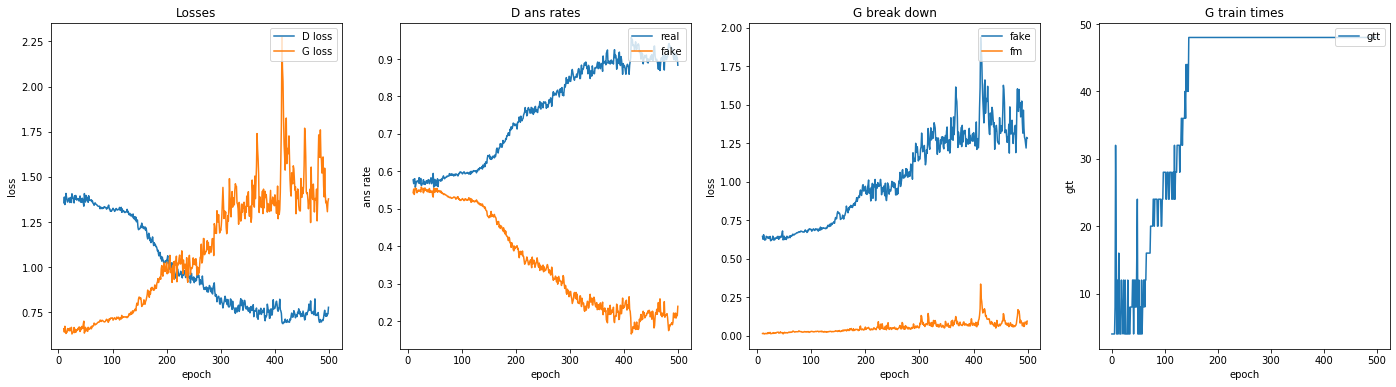

In [17]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=10)

5 images found in ../datasets/theorytab/midinet/learning/midinet_sa
0: fake_samples_epoch100.png
1: fake_samples_epoch200.png
2: fake_samples_epoch300.png
3: fake_samples_epoch400.png
4: fake_samples_epoch500.png
input the number of image:0


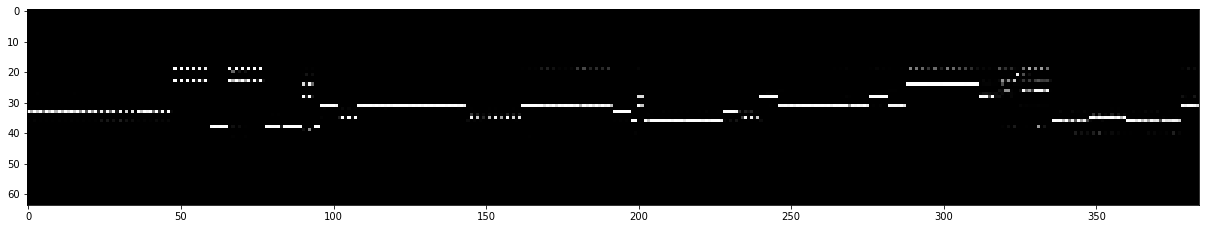

In [21]:
show_sample(save_dir)